<a href="https://colab.research.google.com/github/KatherineElkins/programming-humanity-2025/blob/main/axelrod_model_explanatory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Axelrod Model of Cultural Dissemination: An Educational Guide

## Introduction

This notebook simulates Robert Axelrod's groundbreaking model from his 1997 paper "The Dissemination of Culture: A Model with Local Convergence and Global Polarization" ([link to paper](https://journals.sagepub.com/doi/10.1177/0022002797041002001)).

### The Central Paradox

Axelrod's model addresses a fascinating paradox in cultural dynamics:
- **Local convergence**: People who interact tend to become more similar
- **Global polarization**: Yet distinct cultural regions persist in the world

How can both be true simultaneously?

### Key Insight

The model demonstrates that **similarity breeds interaction, which breeds further similarity**. But once agents become too different, interaction stops, creating stable cultural boundaries. This simple mechanism can explain both convergence within groups and polarization between them.

### Implementation Notes

We use the Mesa agent-based modeling framework ([documentation](https://mesa.readthedocs.io/en/stable/)) and modify the original grid-based model to use random networks instead, making it more flexible for exploring different social structures.

**Updated for Mesa 3.x compatibility by K Elkins, November 2025**

## Model Mechanics: How It Works

### Conceptual Framework

Imagine each person in a society has multiple **cultural features** (think: political views, religious beliefs, musical taste, fashion preferences, food choices, etc.). Each feature can take on one of several possible **traits** (for politics: liberal/moderate/conservative; for food: vegetarian/pescatarian/omnivore; etc.).

### The Algorithm

At each time step:

1. **Select** a random agent and one of their neighbors in the social network
2. **Calculate similarity**: Count how many features they share
   - Interaction probability: $P = \frac{\text{number of shared features}}{\text{total features}}$
3. **Interact (maybe)**: With probability $P$, the agent adopts one of the neighbor's traits where they differ

### Why This Creates Polarization

- If agents are **very similar** (share many features), they're **likely to interact** and become more similar
- If agents are **very different** (share few features), they're **unlikely to interact**, so differences persist
- This creates a "rich get richer" dynamic for similarity, leading to distinct cultural clusters

### Mathematical Formulation

Each agent $i$ has $F$ features: $\vec{c_i} = (c_i^1, c_i^2, ..., c_i^F)$

Each feature can take one of $q$ traits: $c_i^f \in \{0, 1, ..., q-1\}$

Similarity between agents $i$ and $j$: $s_{ij} = \frac{1}{F}\sum_{f=1}^{F} \delta(c_i^f, c_j^f)$

where $\delta(x,y) = 1$ if $x=y$, else $0$

## Installation

First, we need to install the required packages. This cell installs:
- **mesa**: The agent-based modeling framework
- **matplotlib**: For creating visualizations
- **networkx**: For managing and analyzing network structures

In [1]:
!pip install mesa matplotlib networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 3.2 MB/s eta 0:00:00


## Import Libraries

In [2]:
from mesa import Agent, Model
from mesa.datacollection import DataCollector
from mesa.space import NetworkGrid
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt

## Defining the Agent and Model Classes

This cell contains the core logic of the simulation. We define two classes:

### AxelrodAgent
Represents a single person in the society with their cultural features.

### AxelrodModel
Manages the entire simulation, including:
- Creating and placing agents on a network
- Running the interaction logic each time step
- Collecting data about cultural differences over time

In [3]:
class AxelrodAgent(Agent):
    """Individual agent representing a person with cultural features.

    Each agent has a feature vector that represents their cultural traits
    across multiple dimensions (politics, religion, fashion, etc.).
    """

    def __init__(self, model, node_id, feat, trt):
        """Initialize agent with random cultural features.

        Args:
            model: The AxelrodModel this agent belongs to
            node_id: The network node this agent occupies
            feat: Number of cultural features (dimensions)
            trt: Number of possible traits per feature (values per dimension)
        """
        super().__init__(model)
        self.node_id = node_id  # Store the network node ID

        # Create a random feature vector
        # Example: [2, 0, 4, 1, 3] means trait 2 for feature 0, trait 0 for feature 1, etc.
        self.feature = np.random.randint(low=0, high=trt, size=feat)

    def step(self):
        """Agent step - not used in this model.

        We handle interactions at the model level instead of having each
        agent act independently, since Axelrod's model involves pairwise interactions.
        """
        pass


class AxelrodModel(Model):
    """Model containing N agents connected in a social network.

    This class orchestrates the entire simulation, managing agent interactions
    and tracking cultural convergence over time.
    """

    def __init__(self, N, Graph, feat, trt):
        """Initialize the model with agents placed on a network.

        Args:
            N: Number of agents
            Graph: NetworkX graph defining social connections
            feat: Number of cultural features per agent
            trt: Number of possible traits per feature
        """
        super().__init__()
        self.graph = Graph
        self.no_features = feat
        self.no_agents = N
        self.G = NetworkGrid(Graph)  # Mesa's network space

        # Create agents and place them on network nodes
        # Mesa 3.x automatically assigns unique_id to each agent
        for i in range(self.no_agents):
            a = AxelrodAgent(self, i, feat, trt)
            self.G.place_agent(a, i)  # Place agent on network node i

        # Set up data collection to track cultural differences over time
        self.datacollector = DataCollector(
            model_reporters={"Difference": self.calculate_difference}
        )

    def calculate_difference(self):
        """Calculate the average cultural distance across all network edges.

        This metric tells us how culturally diverse the population is.
        Higher values = more diversity; lower values = more homogeneity.

        Returns:
            float: Average absolute difference in features across all connections
        """
        diff = 0
        conn = nx.edges(self.graph)

        # Map network nodes to their agents
        node_to_agent = {agent.node_id: agent for agent in self.agents}

        edge_count = 0
        for edge in conn:
            # For each connection in the network
            if edge[0] in node_to_agent and edge[1] in node_to_agent:
                agent1 = node_to_agent[edge[0]]
                agent2 = node_to_agent[edge[1]]

                # Calculate how different their features are
                # Example: [2,0,4] vs [2,1,4] has difference of 1 in position 1
                diff += np.mean(np.abs(agent1.feature - agent2.feature))
                edge_count += 1

        return diff if edge_count == 0 else diff

    def step(self):
        """Execute one time step of the model.

        This implements Axelrod's core algorithm:
        1. Pick a random agent and neighbor
        2. Calculate their similarity
        3. Interact with probability proportional to similarity
        4. If they interact, agent adopts one of neighbor's differing traits
        """
        # Record current state
        self.datacollector.collect(self)

        # Get all agents
        agent_list = list(self.agents)
        if len(agent_list) == 0:
            return

        # Step 1: Select a random agent
        agent = self.random.choice(agent_list)

        # Get this agent's neighbors in the network
        neighbors = self.G.get_neighbors(agent.node_id)

        if len(neighbors) > 0:
            # Step 2: Select a random neighbor
            neigh = self.random.choice(neighbors)

            # Step 3: Calculate interaction probability
            # This is the key mechanism: similar agents interact more
            diff = agent.feature - neigh.feature
            # Count how many features differ (non-zero differences)
            num_differences = np.count_nonzero(diff)
            # Probability = proportion of features that are DIFFERENT
            # (Axelrod's original formulation uses similarity, but this is equivalent)
            prob = num_differences / self.no_features

            # Step 4: Interact with calculated probability
            if self.random.random() < prob:
                # Find all features where they differ
                diff_indices = np.nonzero(diff)[0]
                if len(diff_indices) > 0:
                    # Randomly select ONE differing feature
                    index = self.random.choice(diff_indices)
                    # Agent adopts the neighbor's trait for that feature
                    agent.feature[index] = neigh.feature[index]

## 🎯 Experiment 1: Basic Model Parameters

These parameters define the structure of our cultural space and social network. **This is where you can experiment!**

### Parameters to Modify:

#### **features** (currently 5)
- **What it means**: Number of cultural dimensions each person has
- **Try changing to**: 3, 10, or 15
- **What happens**:
  - **Fewer features** → Easier to find common ground → MORE convergence
  - **More features** → Harder to be similar → MORE polarization

#### **traits** (currently 5)
- **What it means**: Number of possible values for each feature
- **Try changing to**: 2, 10, or 20
- **What happens**:
  - **Fewer traits** → More likely to match by chance → MORE convergence
  - **More traits** → More cultural diversity → MORE polarization

#### **N** (currently 50)
- **What it means**: Number of people in the population
- **Try changing to**: 20, 100, or 200
- **What happens**: Larger populations may show more complex clustering patterns

#### **P** (currently 0.1)
- **What it means**: Probability of connection between any two people (network density)
- **Try changing to**: 0.05, 0.2, or 0.3
- **What happens**:
  - **Lower P** → Fewer connections → MORE isolated cultural clusters
  - **Higher P** → More connections → MORE convergence

#### **steps** (currently 10000)
- **What it means**: How long the simulation runs
- **Try changing to**: 5000, 20000, or 50000
- **What happens**: Longer runs allow the system to reach equilibrium

### 💡 Suggested Experiments:

1. **"Two-state culture"**: Set `traits = 2` (like binary political views)
2. **"Highly connected society"**: Set `P = 0.3` (social media effect?)
3. **"Sparse network"**: Set `P = 0.05` (isolated communities)
4. **"Complex culture"**: Set `features = 15, traits = 10`

In [4]:
# ═══════════════════════════════════════════════════════════
# 🎛️  MODIFY THESE PARAMETERS TO RUN DIFFERENT EXPERIMENTS
# ═══════════════════════════════════════════════════════════

features = 5      # Number of cultural features per agent
traits = 5        # Number of possible values for each feature
N = 50            # Number of agents
P = 0.1           # Probability of edge in random graph (network density)
steps = 10000     # Number of simulation steps

# ═══════════════════════════════════════════════════════════

# Generate the social network using Erdős-Rényi random graph model
# Each pair of nodes is connected with probability P
G = nx.erdos_renyi_graph(N, P)

# Display network properties
print(f"Network Properties:")
print(f"════════════════════")
print(f"  Nodes: {G.number_of_nodes()}")
print(f"  Edges: {G.number_of_edges()}")
print(f"  Average degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
print(f"\nCultural Space:")
print(f"════════════════════")
print(f"  Features per agent: {features}")
print(f"  Traits per feature: {traits}")
print(f"  Possible combinations: {traits**features:,}")

Network Properties:
════════════════════
  Nodes: 50
  Edges: 130
  Average degree: 5.20

Cultural Space:
════════════════════
  Features per agent: 5
  Traits per feature: 5
  Possible combinations: 3,125


## Running the Simulation

This cell executes the model for the specified number of steps. Each step involves:
1. Selecting a random agent-neighbor pair
2. Calculating their similarity
3. Potentially updating one feature

The progress will be printed every 1000 steps.

In [5]:
# Initialize the model with our parameters
model = AxelrodModel(N, G, features, traits)

print(f"\n🚀 Running simulation for {steps:,} steps...\n")
print("Progress:")
print("─" * 40)

# Run the simulation
for i in range(steps):
    model.step()
    if (i + 1) % 1000 == 0:
        print(f"  ✓ Step {i + 1:>6,}/{steps:,}")

print("─" * 40)
print("\n✅ Simulation complete!\n")


🚀 Running simulation for 10,000 steps...

Progress:
────────────────────────────────────────
  ✓ Step  1,000/10,000
  ✓ Step  2,000/10,000
  ✓ Step  3,000/10,000
  ✓ Step  4,000/10,000
  ✓ Step  5,000/10,000
  ✓ Step  6,000/10,000
  ✓ Step  7,000/10,000
  ✓ Step  8,000/10,000
  ✓ Step  9,000/10,000
  ✓ Step 10,000/10,000
────────────────────────────────────────

✅ Simulation complete!



## 📊 Visualizing Cultural Convergence

This plot shows how cultural differences change over time.

### What to Look For:

- **Steep initial decline**: Agents rapidly converge when they have many opportunities to match
- **Plateau**: System reaches a stable state where remaining differences are protected by dissimilarity
- **Final value**:
  - **Near 0**: Almost complete convergence (monoculture)
  - **Higher value**: Persistent cultural diversity (multiple distinct groups)

### Questions to Consider:

1. Does the system reach equilibrium, or is it still changing?
2. What percentage of the initial diversity remains?
3. How do your parameter changes affect the convergence pattern?

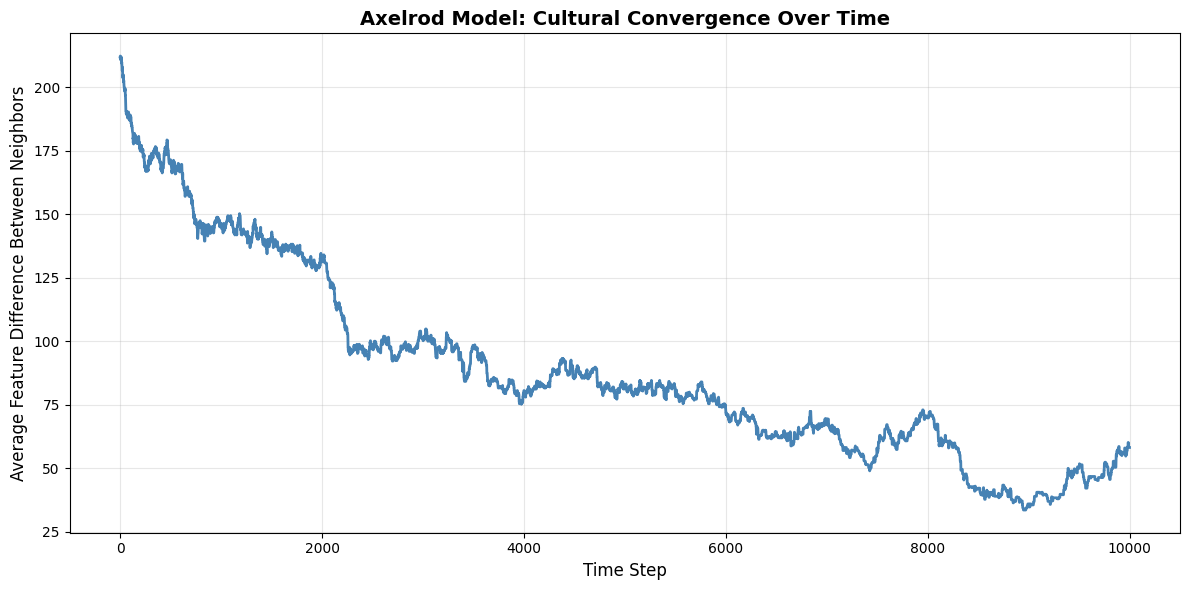


══════════════════════════════════════════════════
CONVERGENCE ANALYSIS
══════════════════════════════════════════════════
Initial average difference:  211.8000
Final average difference:    58.2000
Reduction in diversity:      72.5%

💡 Interpretation: Strong convergence with minimal diversity
══════════════════════════════════════════════════



In [6]:
# Extract the collected data
data = model.datacollector.get_model_vars_dataframe()

# Create the convergence plot
plt.figure(figsize=(12, 6))
plt.plot(data['Difference'], linewidth=2, color='steelblue')
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Feature Difference Between Neighbors', fontsize=12)
plt.title('Axelrod Model: Cultural Convergence Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
initial_diff = data['Difference'].iloc[0]
final_diff = data['Difference'].iloc[-1]

print("\n" + "═" * 50)
print("CONVERGENCE ANALYSIS")
print("═" * 50)
print(f"Initial average difference:  {initial_diff:.4f}")
print(f"Final average difference:    {final_diff:.4f}")
if initial_diff > 0:
    reduction = (1 - final_diff/initial_diff) * 100
    print(f"Reduction in diversity:      {reduction:.1f}%")

    if reduction > 90:
        print("\n💡 Interpretation: Nearly complete convergence (monoculture)")
    elif reduction > 70:
        print("\n💡 Interpretation: Strong convergence with minimal diversity")
    elif reduction > 40:
        print("\n💡 Interpretation: Moderate convergence with persistent subcultures")
    else:
        print("\n💡 Interpretation: Limited convergence, strong polarization")
print("═" * 50 + "\n")

## 🗺️ Network Visualization: Cultural Clusters

This visualization shows the final state of the network with agents colored by their cultural features.

### How to Read This Plot:

- **Each node** = one agent (person)
- **Each edge** = social connection
- **Node color** = cultural identity (hash of feature vector)
- **Similar colors** = similar cultural features
- **Different colors** = different cultural features

### What Patterns Might You See?

1. **Monochrome network**: Complete cultural convergence
2. **Distinct clusters**: Separate cultural regions with different colors
3. **Gradient patterns**: Gradual cultural transitions
4. **Isolated nodes**: Cultural "holdouts" different from neighbors

### 🔍 Things to Investigate:

- Are similar agents clustered together in the network?
- Do you see sharp boundaries between cultural groups?
- How does network structure (connectivity) relate to cultural patterns?

/tmp/ipython-input-942786842.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


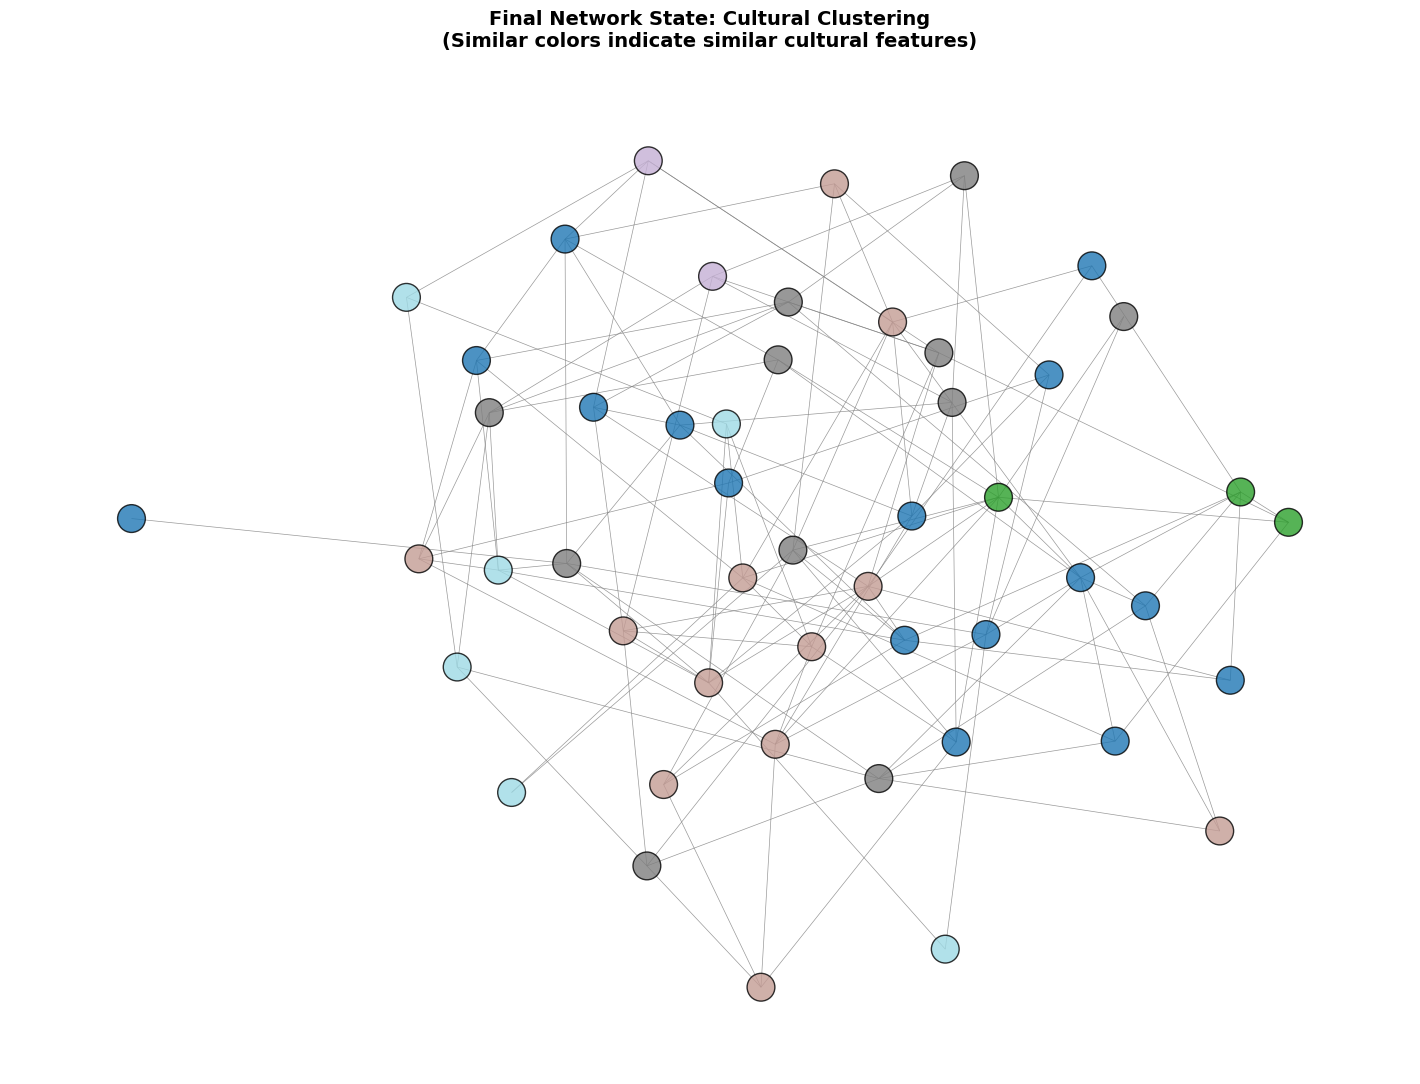


📊 Number of distinct cultural groups: 9
   (out of 50 total agents)



In [7]:
# Create a color mapping based on cultural features
node_to_agent = {agent.node_id: agent for agent in model.agents}
colors = []

for node in G.nodes():
    if node in node_to_agent:
        # Use the feature vector as a unique identifier
        # Agents with identical features will have the same color
        feature_tuple = tuple(node_to_agent[node].feature)
        colors.append(hash(feature_tuple))
    else:
        colors.append(0)

# Create the network visualization
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42, k=0.5)  # k controls spacing
nx.draw(G, pos,
        node_color=colors,
        node_size=400,
        cmap='tab20',  # Colormap with distinct colors
        with_labels=False,
        alpha=0.8,
        edge_color='gray',
        width=0.5,
        edgecolors='black',  # Black outline around nodes
        linewidths=1)
plt.title('Final Network State: Cultural Clustering\n' +
          '(Similar colors indicate similar cultural features)',
          fontsize=14, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

# Count distinct cultural groups
unique_cultures = len(set(colors))
print(f"\n📊 Number of distinct cultural groups: {unique_cultures}")
print(f"   (out of {N} total agents)\n")

## 🧠 Theoretical Insights and Discussion

### Key Findings from the Axelrod Model

1. **Local convergence**: Agents who interact tend to become more similar over time
2. **Global polarization**: Despite local convergence, distinct cultural regions can form and persist
3. **Similarity breeds interaction**: Agents are more likely to interact when they already share cultural features
4. **Stable boundaries**: Once agents become sufficiently different, interaction stops, creating persistent cultural divides

### The Convergence-Polarization Paradox

The model elegantly resolves an apparent paradox:
- At the **micro level**: similar agents interact and become more similar (convergence)
- At the **macro level**: this process creates boundaries between dissimilar groups (polarization)

This happens because the interaction probability depends on existing similarity. Once two agents or regions become different enough, they effectively stop influencing each other.

### Real-World Applications

This model has been used to study:
- **Political polarization**: How can democracies have both local consensus and national division?
- **Cultural evolution**: Why do distinct cultures persist despite globalization?
- **Social fragmentation**: How does homophily (similarity breeds connection) affect society?
- **Echo chambers**: Why do online communities become increasingly homogeneous?

### Critical Parameters

The behavior is most sensitive to:
- **Number of features (F)**: More features generally mean more polarization
- **Number of traits (q)**: More traits mean more possible diversity
- **Network structure**: Sparse networks encourage polarization; dense networks encourage convergence

### Extensions and Variations

Researchers have explored:
- **Weighted features**: Some cultural dimensions matter more than others
- **Mass media**: External influences that affect all agents
- **Migration**: Agents changing positions in the network
- **Different network topologies**: Small-world networks, scale-free networks, spatial grids
- **Asymmetric influence**: Opinion leaders who influence but aren't influenced

### Limitations to Consider

1. **Oversimplification**: Real culture is far more complex than feature vectors
2. **No innovation**: The model doesn't create new traits, only redistributes existing ones
3. **Pairwise interactions**: Ignores group dynamics and social movements
4. **Symmetric influence**: In reality, some people have more influence than others
5. **Static network**: Real social networks change over time

### Philosophical Questions

- Does cultural diversity require physical or social barriers?
- Is polarization an inevitable outcome of free interaction?
- What role does network structure play in social cohesion?
- Can we design social systems that balance diversity and consensus?

### References

- Axelrod, R. (1997). The dissemination of culture: A model with local convergence and global polarization. *Journal of Conflict Resolution, 41*(2), 203-226.
- For more on network-based cultural models, see Castellano, C., Fortunato, S., & Loreto, V. (2009). Statistical physics of social dynamics. *Reviews of Modern Physics, 81*(2), 591.

## 🎯 Suggested Experiments to Run Next

Now that you've seen the basic model, try these experiments by modifying the parameters above:

### Experiment 1: Binary Culture
```python
features = 5
traits = 2      # Change to 2
N = 50
P = 0.1
steps = 10000
```
**Question**: Does having only two options per feature lead to complete convergence or persistent polarization?

### Experiment 2: Hyper-Connected Society
```python
features = 5
traits = 5
N = 50
P = 0.3         # Change to 0.3
steps = 10000
```
**Question**: Does a more connected network lead to more cultural homogeneity?

### Experiment 3: Sparse Network
```python
features = 5
traits = 5
N = 50
P = 0.05        # Change to 0.05
steps = 20000   # Longer run needed
```
**Question**: Do isolated communities maintain more diverse cultures?

### Experiment 4: Complex Culture
```python
features = 10   # Change to 10
traits = 10     # Change to 10
N = 50
P = 0.1
steps = 20000
```
**Question**: Does cultural complexity prevent convergence?

### Experiment 5: Large Population
```python
features = 5
traits = 5
N = 200         # Change to 200
P = 0.05
steps = 30000
```
**Question**: Do larger populations show different patterns of cultural clustering?

---

**After each experiment, consider**:
1. How many distinct cultural groups emerge?
2. What percentage of initial diversity is lost?
3. Does the system reach equilibrium or keep changing?
4. How does the network structure relate to cultural patterns?